# Введение в машинное обучение

## Семинар #7

### Екатерина Кондратьева

ekaterina.kondrateva@skoltech.ru

code credit @artonson

## Обучение без учителя. Поиск аномалий (Anomaly Detection)

In [171]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

## Кто такие аутлайеры (аномалии)? 

Это наблюдение, которое "**отличается**" "**настолько сильно**" от "**прочих наблюдений**"

##### Назовите самый простой способ детектирования аномалий?

*Спойлер: СТД? Квантили?*

## 1.  Ищем фрод

Источник: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [172]:
data = pd.read_csv("./data/creditcard.csv")

Давайте проверим, сколько "фрода" в этой выборке?

In [173]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
11258,19546.0,-0.454749,-4.054983,-0.273254,-0.399568,-2.590132,-0.393092,0.138466,-0.391686,-0.873562,...,0.054097,-1.563757,-0.628145,0.457243,-0.338810,-0.653193,-0.184372,0.185015,1002.00,0
78321,57475.0,-6.423197,1.072629,-3.820238,-0.269845,-4.125205,-0.690805,-0.196968,2.840871,-0.307457,...,0.011082,0.109586,-0.041425,0.576822,-0.291755,0.837947,-0.077805,-0.788987,255.30,0
226814,144808.0,-2.405207,2.943823,-7.616654,3.533374,-5.417494,-0.112632,-1.329372,1.709417,-2.322716,...,0.652683,0.414132,0.023869,-0.260616,0.405316,0.029107,0.519807,-0.469537,667.55,1
276476,167121.0,-0.454736,0.189683,0.839674,-0.810172,0.458127,0.106038,0.427228,0.195571,-1.232442,...,-0.136466,0.090678,-0.255906,0.628284,0.175469,-0.617653,0.147898,0.142017,9.94,0
174521,121948.0,0.014204,0.516012,0.248349,-0.307436,0.180279,1.025058,-0.806851,-1.255250,0.843365,...,1.673448,0.206028,-0.294641,0.199466,0.902569,0.829324,0.220143,0.262698,7.50,0


In [174]:
data['Class'].value_counts()

0    28432
1      492
Name: Class, dtype: int64

In [175]:
492/28432

0.01730444569499156

Должно быть  1.7% , что можно сказать про баланс классов?

In [176]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,...,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000,28924.000000
mean,94597.165641,-0.063516,0.075994,-0.116809,0.083753,-0.054695,-0.016576,-0.078323,0.015787,-0.039995,...,0.010800,-0.000310,-0.004370,-0.000643,-0.000772,0.002518,0.002694,0.001286,87.285667,0.017010
std,47526.033582,2.173112,1.697883,1.935877,1.546847,1.556783,1.348886,1.649011,1.431676,1.170255,...,0.862053,0.742108,0.565251,0.605248,0.520625,0.481248,0.434112,0.345710,235.492046,0.129311
min,0.000000,-30.552380,-40.978852,-31.103685,-5.683171,-32.092129,-17.118592,-43.557242,-41.484823,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.822684,-4.781606,-1.664130,-9.895244,-8.478686,0.000000,0.000000
25%,53988.250000,-0.940423,-0.579151,-0.962786,-0.824836,-0.703097,-0.787944,-0.569843,-0.206605,-0.658765,...,-0.228051,-0.546631,-0.160934,-0.356201,-0.316206,-0.325299,-0.070677,-0.052643,5.390000,0.000000
50%,84602.500000,0.008535,0.078486,0.152450,0.016759,-0.062998,-0.290597,0.031023,0.028303,-0.067754,...,-0.024851,0.006007,-0.011446,0.042417,0.014036,-0.049536,0.001890,0.011664,21.950000,0.000000
75%,139215.250000,1.314801,0.834686,1.007704,0.798441,0.604570,0.395795,0.557633,0.344750,0.588573,...,0.192924,0.532145,0.145472,0.440141,0.346935,0.246329,0.094998,0.079820,76.000000,0.000000
max,172786.000000,2.412720,22.057729,4.069865,12.114672,24.345310,21.393069,34.303177,20.007208,7.937988,...,27.202839,8.361985,12.045536,3.695503,3.347936,3.004455,10.135597,15.769636,7712.430000,1.000000


In [177]:
full_X = data.drop(columns="Class")
full_y = data["Class"]

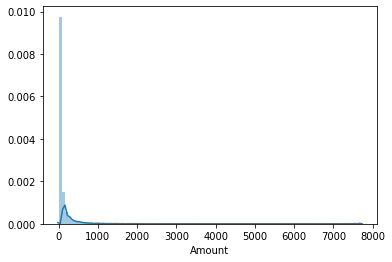

In [178]:
import seaborn as sns
sns.distplot(data["Amount"], bins = 100)

## Нормально ли распределены характеристики?

In [179]:
features_to_plot = ['Amount','Time','V1', 'V2']

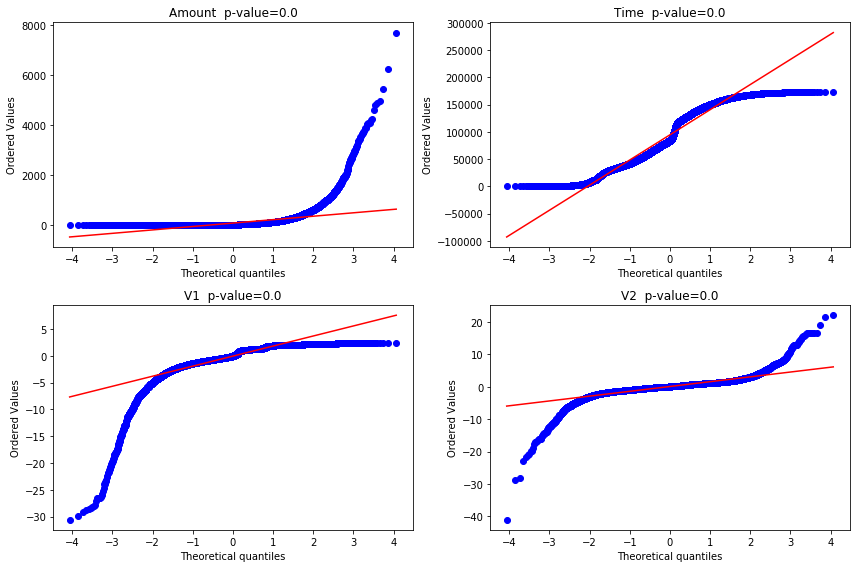

In [180]:
import scipy.stats as stats
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, feature in enumerate(features_to_plot):
    ax = axes[i // 2, i % 2]
    stats.probplot(data[feature].dropna(), dist="norm", plot=ax)
    ax.set_title(feature + '  p-value=' + "{:.3}".format(stats.shapiro(data[feature].dropna())[1]))

plt.tight_layout()
plt.show()

Будем делать **красиво**:
    
    - отложим заранее из оригинальной выборки тестовую, размером 0.4
    - будем выбирать модель кросс валидацией на выборке `train`
    - не забудем про стратификацию

In [181]:
from sklearn.model_selection import train_test_split

full_X.reset_index(drop=True)

tt_split = train_test_split(full_X, full_y, test_size=0.4, stratify=full_y)

train_X, test_X, train_y, test_y = tt_split 

Будем делать **красиво**, выберем несколько метрик:
    
    1. стандартно `accuracy`, почему это плохо в нашем случае?
    2. `precision_score` или доля истинных 1 среди всех помеченных как 1
    3. `recall_score` или полнота "вероятность", с которой все истинные 1 предсказаны как 1
    4. `fbeta_score` - частный случай которого, наш знакомый `f1_score` 

In [182]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, fbeta_score, f1_score

Зачем нам $\beta$ ? : https://en.wikipedia.org/wiki/F1_score

Возьмем $\beta = .17$ как будто, мы заранее знаем, сколько нам ожидать фрода в выборке.

In [183]:
def show_metrics(y_true, y_pred):
    return pd.Series(
        {
        "accuracy": accuracy_score(y_true, y_pred),
            
        "roc_auc": roc_auc_score(y_true, y_pred),
        
        "precision": precision_score(y_true, y_pred),# ratio tp / (tp + fp)
        
        "recall": recall_score(y_true, y_pred), # recall is the ratio tp / (tp + fn) 
        
        "f1_score": f1_score(y_true, y_pred),
        
        "f_0.2": fbeta_score(y_true, y_pred, beta=.17),
    }
)

## Обнаружение выбросов

In [184]:
# author @artonson

def plot_clustering(model, data, size=100):
    def _expand(a, b, frac=.5, margin=1.):
        return a - abs(a) * frac - margin, b + abs(b) * frac + margin

    # Вспомогательная функция для рисования линий уровня и набора точек
    plt.figure(figsize=(9, 5))
    min_x, min_y = data.min(axis=0)
    max_x, max_y = data.max(axis=0)
    min_x, max_x = _expand(min_x, max_x)
    min_y, max_y = _expand(min_y, max_y)

    # создаём регулярную сетку для контуров
    all_x = np.linspace(min_x, max_x, num=size)
    all_y = np.linspace(min_y, max_y, num=size)
    XX, YY = np.meshgrid(all_x, all_y)
    test_data = np.c_[XX.ravel(), YY.ravel()]

    # опрашиваем предсказания модели
    try:
        predictions = model.decision_function(test_data).reshape(size, size)
        data_scores = model.predict(data)
        anomaly_scores = model.decision_function(data)

    except AttributeError:
        predictions = model._decision_function(test_data).reshape(size, size)
        data_scores = model._predict(data)
        anomaly_scores = model._decision_function(data)

    # создаём график контуров с заливкоц
    plt.contourf(all_x, all_y, predictions, cmap=plt.cm.coolwarm)

    # отображаем границу принятия решений
    threshold = anomaly_scores[data_scores==1.0].min()
    plt.contour(XX, YY, predictions, levels=[threshold], linewidths=1)

    # нарисуем точки выборки
    plt.scatter(data[:, 0], data[:, 1])

    axes = plt.gca()
    axes.set_xlim([min_x,max_x])
    axes.set_ylim([min_y,max_y])

    plt.show()
    plt.close()

Создаём несколько скоплений точек и подмешиваем аномальных точек

In [185]:
from sklearn.datasets import make_blobs


def data_generator(n_samples=100, anomaly_fraction=0.1, n_features=2):
    n_anomaly = int(n_samples * anomaly_fraction)
    n_normal = n_samples - n_anomaly

    normal_data, _ = make_blobs(n_normal, n_features=n_features, centers=3)#какое это распределение?

    anomaly_data = np.random.rand(n_anomaly, n_features)

    nrm_min = normal_data.min(axis=0).reshape(1, -1)
    nrm_ptp = normal_data.ptp(axis=0).reshape(1, -1)
    anomaly_data = anomaly_data * nrm_ptp + nrm_min

    return np.concatenate([normal_data, anomaly_data], axis=0)

Создаём несколько скоплений точек, к которым подмешаны аномалии

In [186]:
data_blobs = data_generator()

<br>

### Эллиптическая Огибающая

Метод **Elliptic Envelope** оценивая ковариацию данных предполагает, что 
* данные порожденные эллиптическим распределением

* аномальные точки находятся дальше от центра скопления, чем нормальные

In [187]:
from sklearn.covariance import EllipticEnvelope

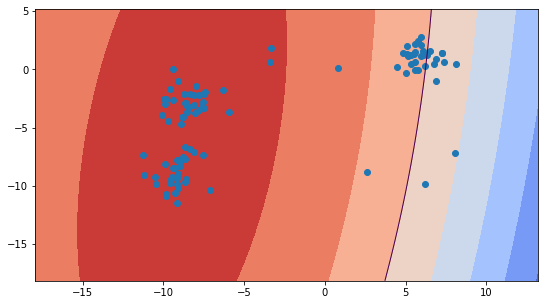

In [188]:
model = EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=42)

model.fit(data_blobs)

plot_clustering(model, data_blobs)

+ простой в использовании метод
+ порождает интерпретируемую границу
- годится только для распредений с одним цетром (одномодальных)

Посмотрим на его работу в обнаружении мошенничества

#### А как выгладит распредление наших переменых?

In [189]:
model = EllipticEnvelope(random_state=42, contamination=0.02)

model.fit(train_X)

predictions_elliptic = -model.decision_function(test_X)

labels_elliptic = model.predict(test_X)

In [190]:
max(-predictions_elliptic), min(-predictions_elliptic)

(249212.51449158828, -21161818.337737232)

In [191]:
labels_elliptic

array([1, 1, 1, ..., 1, 1, 1])

In [192]:
(labels_elliptic < 0)*1

array([0, 0, 0, ..., 0, 0, 0])

In [193]:
metrics_elliptic = show_metrics(test_y, (labels_elliptic < 0) * 1)
metrics_elliptic

accuracy     0.965082
roc_auc      0.535793
precision    0.074074
recall       0.091371
f1_score     0.081818
f_0.2        0.074470
dtype: float64

<br>

### Изолирующий Лес (Isolation Forest)

* для каждого наблюдения рассчитывается средняя длина пути до него в случайном дереве
  * деревья со случайными разбиениями с целью изолировать наблюдения
  
* чем короче средняя длина пути тем проще описать наблюдение
  * тем в более изолированной части пространства оно находится

* чем больше разбиений нужно для наблюдения, нормальнее оно

In [194]:
from sklearn.ensemble import IsolationForest

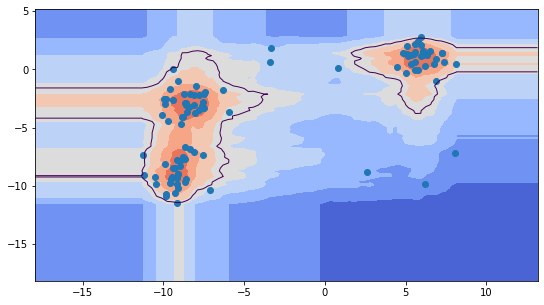

In [195]:
model = IsolationForest(random_state=42)
model.fit(data_blobs)

plot_clustering(model, data_blobs)

Минусы: не различает скопления аномалий

In [196]:
model = IsolationForest(random_state=42, contamination=0.0173)

model.fit(train_X)

predictions_isolation = -model.decision_function(test_X)

labels_isolation = model.predict(test_X)

## Выберем только тех, кого метод назвал аутлайерами

In [197]:
test_X[(labels_isolation < 0).tolist()]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
106523,69997.0,-13.631215,-2.801461,-8.590126,5.428348,-11.052770,3.927013,1.897916,4.355972,-2.710827,...,-3.443397,-0.319633,-1.274384,-4.641780,0.250522,-1.465515,-0.289065,-1.404203,-2.233774,985.81
234173,147861.0,-11.259023,6.014025,-6.628890,0.827753,-5.457142,-0.401600,-5.307798,6.228680,0.105322,...,-3.027337,0.335788,-1.396907,0.875063,0.527716,-0.244499,-1.521585,-6.095004,-0.913046,23.89
30496,35953.0,-4.844372,5.649439,-6.730396,5.252842,-4.409566,-1.740767,-6.311699,3.449167,-5.416284,...,0.284555,1.194888,-0.845753,0.190674,-0.216443,-0.325033,-0.270328,0.210214,0.391855,111.70
56186,47305.0,-6.750535,-13.320260,-3.863806,3.343289,-4.523683,1.965882,4.775345,-0.695991,-0.025065,...,8.135404,2.498960,-1.917072,-3.532086,-0.014758,-1.426262,0.623231,-0.801476,0.699637,4080.30
12184,21259.0,-7.179612,-9.916182,2.288163,1.853324,8.106762,-6.008567,-6.371899,1.005078,2.858103,...,2.459520,0.745055,-0.495509,2.204114,0.008976,-0.649965,0.700071,-0.269628,0.371576,116.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61333,49780.0,-10.186103,-7.379574,-5.998875,0.708397,-12.406169,7.144305,11.383023,-1.880443,0.584080,...,-5.847836,-2.323904,1.310615,-1.372017,0.292457,0.548592,0.017344,1.836418,3.248848,2677.00
12108,21046.0,-16.917468,9.669900,-23.736443,11.824990,-9.830548,-2.514829,-17.290657,1.820408,-6.264903,...,0.996745,-2.336111,0.972755,1.241866,-1.051086,0.038009,0.672317,2.108471,-1.421243,1.00
30551,35980.0,-17.716437,-12.410982,-6.030176,6.026010,-1.350931,-2.113742,0.077972,1.295241,-0.056984,...,-8.654987,-2.528944,0.374600,0.336529,1.159184,1.146854,0.210469,4.249607,-8.478686,1.00
229859,146082.0,-18.065915,-20.943103,-4.581048,4.438972,7.625662,-6.192213,-4.715975,-3.867424,3.612216,...,-18.598172,-6.218399,-0.532113,-13.277950,1.603244,-4.541069,-0.301654,10.135597,-3.783710,2687.48


In [198]:
metrics_isolation = show_metrics(test_y, (labels_isolation < 0) * 1)
metrics_isolation 

accuracy     0.983924
roc_auc      0.749894
precision    0.529101
recall       0.507614
f1_score     0.518135
f_0.2        0.528472
dtype: float64

<br>

## Local Outlier Factor

Основан на наблюдении, что нормальные наблюдения имеют тенденцию **скапливаться**

* вводится показатель локальной плотности, обратно пропорциональный средним расстоянием до $k$ ближайших соседей

* попарно сравнивается с показателями соседей

* вычисляется отношение локальной аномальности

Метод: https://towardsdatascience.com/local-outlier-factor-for-anomaly-detection-cc0c770d2ebe

In [199]:
from sklearn.neighbors import LocalOutlierFactor

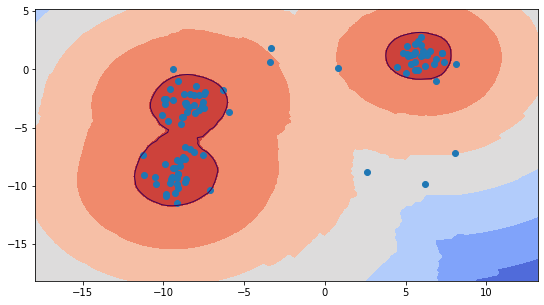

In [200]:
model = LocalOutlierFactor(novelty= True)
model.fit(data_blobs)

plot_clustering(model, data_blobs)

Минусы:
* подвержен проблеме "проклятия размерности", тк основан на расстояниях
* не может отличить скопления аномалий от нормальных точек

In [201]:
model = LocalOutlierFactor()

model.fit(train_X)

predictions_lof = -model._decision_function(test_X)

labels_lof = -predictions_lof

In [202]:
metrics_lof = show_metrics(test_y, (labels_lof < 0) * 1)
print( metrics_lof )

accuracy     0.887900
roc_auc      0.556392
precision    0.035473
recall       0.213198
f1_score     0.060825
f_0.2        0.036323
dtype: float64


## One Class SVM

Основная идея -- отделить данные в спрямляющем пространстве **мягкой гиперплоскостью** от нуля

Решает задачу
\begin{aligned}
  & \underset{\rho, f\in \mathcal{H}}{\text{минимизировать}}
    & & \tfrac12 \|f\|^2 - \rho
        + \tfrac1{m \nu} \sum_{i=1}^m \max\bigl\{
            0, \rho - f(x_i) \bigr\}\,,
\end{aligned}

Визуализация одноклассового метода опорных векторов: http://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/

Визуализация `gamma` для `rbf` ядра: https://bitquill.net/blog/quick-hack-visualizing-rbf-bandwidth/

In [203]:
from sklearn.svm import OneClassSVM

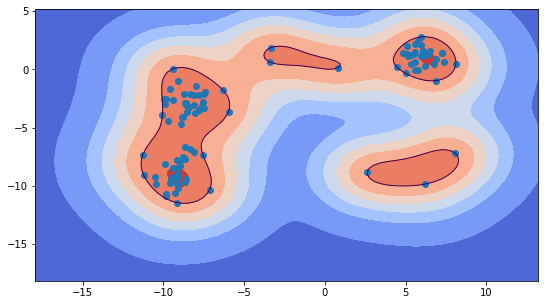

In [204]:
model = OneClassSVM(nu=0.1, kernel='rbf', gamma=0.1)

model.fit(data_blobs)

plot_clustering(model, data_blobs)

Плюсы:
* непараметрический метод
* применим не только к объектам из $\mathbb{R}^n$ (линейного пространства)
  * ядра на строках, графах и пр.
* может быть полезным при разумном выборе ядра

Минусы:
* вычислительно затратен и плохо масштабируется

In [205]:
train_X.shape

(17354, 30)

In [206]:
model = OneClassSVM(random_state = 42, nu = 0.0173)

model.fit(train_X)

predictions_svm = model.decision_function(test_X)

labels_svm = model.predict(test_X)

In [207]:
labels_svm

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [208]:
metrics_svm = show_metrics(test_y, ~(labels_svm < 0) * 1)
print(metrics_svm )

accuracy     0.982714
roc_auc      0.509845
precision    0.363636
recall       0.020305
f1_score     0.038462
f_0.2        0.246542
dtype: float64


<br>

## Бинарная классификация

Воспользуемся логистической регрессией

In [209]:
from sklearn.linear_model import LogisticRegression


estimator = LogisticRegression(class_weight=None)

grid = {
    "C" : np.logspace(-3, +3, num=10)
}

Будем стараться честно построить модель

In [210]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score)

In [211]:
from sklearn.model_selection import StratifiedKFold

st_kfold = StratifiedKFold(n_splits=5)

Оценим лог-регрессию с кросс валидацией

In [212]:
cv_grid = GridSearchCV(estimator, grid, scoring=f1_scorer, cv=st_kfold, n_jobs=1)

cv_grid.fit(train_X, train_y) ;

Оценим метрики для самой лучшей модели по валидации

In [213]:
logistic_naive = cv_grid.best_estimator_

logistic_naive_test_pred = logistic_naive.predict(test_X)

metrics_logistic_naive = show_metrics(test_y, logistic_naive_test_pred)

In [214]:
metrics_logistic_naive

accuracy     0.994036
roc_auc      0.857296
precision    0.915584
recall       0.715736
f1_score     0.803419
f_0.2        0.908460
dtype: float64

Можно ли улучшить `precision` и `recall`?

<br>

### Балансировка и Ресэмплинг

Функция потерь, взвешенная по меткам класса:
\begin{aligned}
  & \underset{\beta_0, \beta}{\text{минимизировать}}
    & & \tfrac12 \|\beta\|_2^2
        + C w_+ \sum_{i\colon y_i = +1} l\bigl(+1, f(x_i)\bigr)
        + C w_- \sum_{i\colon y_i = -1} l\bigl(-1, f(x_i)\bigr)
\end{aligned}

* дефолтный вариант $w_+ = w_- = 1$.

* сбалансированный вариант $w_+ = \tfrac{m}{2 n_+}$ и $w_- = \tfrac{m}{2 n_-}$.

В данном случае, мы делаем поправку на колличество представителей классов $n_ -$ и $n_+$

In [215]:
estimator = LogisticRegression(class_weight = "balanced")

cv_grid = GridSearchCV(estimator, grid, scoring=f1_scorer, cv = st_kfold, n_jobs = 1)

cv_grid.fit(train_X, train_y) ;

In [216]:
logistic_balanced = cv_grid.best_estimator_

logistic_balanced_test_pred = logistic_balanced.predict(test_X)

metrics_logistic_balanced = show_metrics(test_y, logistic_balanced_test_pred)

In [217]:
metrics_logistic_balanced

accuracy     0.977701
roc_auc      0.921316
precision    0.423940
recall       0.862944
f1_score     0.568562
f_0.2        0.430086
dtype: float64

#### Ресэмплинг

Сбалансируем классы в обучающей выборке добавлением наблюдений или изменением их веса.

In [218]:
data.shape

(28924, 31)

In [219]:
from sklearn.utils import check_random_state, safe_indexing


def undersample(X, y, ratio=20, pos_label=1, random_state=None):
    random_state = check_random_state(random_state)

    # отбрасываем случайную долю наблюдений доминирующего класса
    class_major_index = np.flatnonzero(y != pos_label)

    n_major = int(len(class_major_index) / ratio)
    class_major_index = random_state.permutation(class_major_index)
    class_major_index = class_major_index[:n_major]

    # выбираем все примеры минорного класса
    class_minor_index = np.flatnonzero(y == pos_label)

    # составляем новую (временную) обучающую выборку
    indices = np.r_[class_major_index, class_minor_index]

    return safe_indexing(X, indices), safe_indexing(y, indices)

Прореживание доминирующего класса может плохо обобщить из-за нехватки данных!

In [220]:
estimator = LogisticRegression(class_weight=None)

Выделим из текущего трейна валидацоннный набор

In [221]:
dev_X, val_X, dev_y, val_y = train_test_split(train_X, train_y, test_size=0.25,
                                              stratify=train_y, random_state=321)

Проведём валидацию модели с андерсэмплингом вручную

In [222]:
from sklearn.model_selection import ParameterGrid
from sklearn.base import clone

n_resamples, ratio = 7, 10
par_grid = ParameterGrid(grid)

results_grid = []
for par in par_grid:

    results_resample = []
    for b in range(n_resamples):
        und_X, und_y = undersample(dev_X, dev_y, ratio, pos_label=1, random_state=None)

        cv_estimator = clone(estimator).set_params(**par)
        cv_estimator.fit(und_X, und_y)
        
        cv_val_pred = cv_estimator.predict(val_X)
        results_resample.append(show_metrics(val_y, cv_val_pred))

    results_resample = pd.concat(results_resample, axis=1).T

    results_grid.append((par, results_resample.mean().rename("mean")))

Выбираем $F_1$ метрики и находим наилучшую модель

In [223]:
f1_scores = [(par, met["f1_score"]) for par, met in results_grid]

best_par_, _ = f1_scores[np.argmax([f1 for par, f1 in f1_scores])]

Делаем андерсэмплинг и обучаем модель заново

In [224]:
und_X, und_y = undersample(train_X, train_y, ratio, pos_label=1, random_state=None)

logistic_undersample = clone(estimator).set_params(**best_par_)
logistic_undersample.fit(und_X, und_y)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Считаем метрики

In [225]:
logistic_undersample_test_pred = logistic_undersample.predict(test_X)

metrics_logistic_undersample = show_metrics(test_y, logistic_undersample_test_pred)
print(metrics_logistic_undersample)

accuracy     0.991098
roc_auc      0.828367
precision    0.783133
recall       0.659898
f1_score     0.716253
f_0.2        0.779046
dtype: float64


Сравним метрики

In [226]:
all_metrics = pd.concat(dict([
    ("elliptic", metrics_elliptic),
    ("isolation", metrics_isolation),
    ("svm", metrics_svm),
    ("logistic_naive", metrics_logistic_naive),
    ("logistic_balanced", metrics_logistic_balanced),
    ("logistic_undersample", metrics_logistic_undersample)
]), axis=1)

all_metrics

,elliptic,isolation,svm,logistic_naive,logistic_balanced,logistic_undersample
accuracy,0.965082,0.983924,0.982714,0.994036,0.977701,0.991098
roc_auc,0.535793,0.749894,0.509845,0.857296,0.921316,0.828367
precision,0.074074,0.529101,0.363636,0.915584,0.423940,0.783133
recall,0.091371,0.507614,0.020305,0.715736,0.862944,0.659898
f1_score,0.081818,0.518135,0.038462,0.803419,0.568562,0.716253
f_0.2,0.074470,0.528472,0.246542,0.908460,0.430086,0.779046


##  Задание 1:
повторить эксперименты, имея 10% ключей для выборки

- произвести выбор лучшей стратегии детектирования аномалий на 5% ключей
- предсказать на остальных 5% ключей

In [227]:
from sklearn.model_selection import train_test_split

train_X.reset_index(drop=True)

tt_split = train_test_split(full_X, full_y, test_size=0.1, stratify=full_y, random_state= 42)

train_X, test_X, train_y, test_y = tt_split 

In [228]:
test_X.shape

(2893, 30)

#### Теперь разделим эту выборку на 2 половины `logistic_naive`.

In [229]:
tt_split = train_test_split(test_X, test_y, test_size=0.5, stratify=test_y, random_state= 42)

train_5_X, test_5_X, train_5_y, test_5_y = tt_split 

In [230]:
train_5_X.shape

(1446, 30)

#### Лучшие стратерии на всей выборке для нас были `IsolationForest` и `Logistic naive`

### Начнем с моделей обучения с учителем:
- заполним 90% датасета обучившись на 5% трейновой выборки, проверим результат на тесте 5%
- обучимся на 95% датасета и трейновой выборке, проверим результат на 5%

In [231]:
random_state = 42

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

from sklearn.svm import SVC
svc= SVC(random_state= random_state) # а что есть сделать гиперпараметр class_weigt ='balanced'

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state= random_state)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state= random_state)

In [232]:
from sklearn.metrics import accuracy_score

models = [knn, svc, rfc, lr]

for model in models:
    model.fit(train_5_X, train_5_y)# fit the model
    predictions = model.predict(test_5_X)
    print(str(model)[:10], f1_score(test_5_y, predictions))   

KNeighbors 0.0
SVC(C=1.0, 0.0
RandomFore 0.717948717948718
LogisticRe 0.6842105263157895


#### Заполнять будем моделью на основе случайных лесов. Но сначала попробуем её оптимизировать

In [233]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [234]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
# все делаем теперь по красоте, нам нужен лучший скор
pipe = Pipeline([('standardizer', scaler), ('rfc', rfc)])


# Сетка
search_space = [{'rfc__n_estimators': [10,20,50,100,200],
                'rfc__class_weight': [None, "balanced", "balanced_subsample"]
                }]
# Поиск по сетке
clf = GridSearchCV(pipe, search_space, cv= 5, scoring = 'f1').fit(train_5_X, train_5_y)

##### Посмотрим, увеличился ли скор на тесте для лучшей модели?

In [235]:
predictions = clf.predict(test_5_X)
print(f1_score(test_5_y, predictions))   

0.6842105263157895


не особо, но зато, мы знаем, что это не случайный результат на тесте.

In [236]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('standardizer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rfc',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

Предскажем основной вес датасета и посмотрим, что произойдет со скором на тесте:

In [237]:
predictions = clf.predict(train_X)
len(predictions)

26031

In [238]:
train_95_X = pd.concat([train_X, train_5_X])

In [239]:
train_95_y = np.concatenate((predictions, train_5_y))

In [240]:
clf.fit(train_95_X, train_95_y)
predictions = clf.predict(test_5_X)
print(f1_score(test_5_y, predictions))   

0.6842105263157895


#### Скор на 10-15% хуже чем с размеченной выборкой (но это только при 1 повторении, нужно повторить KFold эксперименты)

### Для Isolation Forest 

In [248]:
labels_isolation.shape

(1447,)

In [249]:
test_5_y.shape

(1447,)

In [252]:
model = IsolationForest(random_state=42, contamination=0.1)# мы знаем долю аномалий из опыта

model.fit(train_95_X)

predictions_isolation = -model.decision_function(test_5_X)

labels_isolation = model.predict(test_5_X)
print(f1_score(test_5_y, (labels_isolation < 0)*1)  ) 

0.21301775147928995


##### Далее обе модели можем использовать для взвешенного предсказания

<br>